In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
%cd /kaggle/working
!git clone https://github.com/ultralytics/ultralytics.git
%cd ultralytics
!pip install -e .

/kaggle/working
Cloning into 'ultralytics'...
remote: Enumerating objects: 59662, done.
remote: Counting objects: 100% (1163/1163), done.
remote: Compressing objects: 100% (596/596), done.
remote: Total 59662 (delta 978), reused 568 (delta 567), pack-reused 58499 (from 4)
Receiving objects: 100% (59662/59662), 32.70 MiB | 26.08 MiB/s, done.
Resolving deltas: 100% (44250/44250), done.
/kaggle/working/ultralytics
Obtaining file:///kaggle/working/ultralytics
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB

In [2]:
import ultralytics
print("✅ Ultralytics path:", ultralytics.__file__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Ultralytics path: /kaggle/working/ultralytics/ultralytics/__init__.py


In [6]:
mkdir -p /kaggle/working/ultralytics/ultralytics/cfg/models/9/


In [7]:
cp /kaggle/working/ultralytics/ultralytics/cfg/models/v9/yolov9m.yaml /kaggle/working/ultralytics/ultralytics/cfg/models/9/yolo9_cbam1.yaml


In [10]:
import shutil

# -------------------- SETUP --------------------

# Paths
original_yaml = '/kaggle/working/ultralytics/ultralytics/cfg/models/v9/yolov9m.yaml'
new_yaml = '/kaggle/working/ultralytics/ultralytics/cfg/models/9/yolo9_cbam1.yaml'

# Copy original YAML
shutil.copyfile(original_yaml, new_yaml)

# Read YAML lines
with open(new_yaml, 'r') as f:
    lines = f.readlines()

# -------------------- MASTER EDIT ZONE --------------------

# Update number of classes (optional)
for i, line in enumerate(lines):
    if line.strip().startswith("nc:"):
        lines[i] = "nc: 13  # number of classes\n"
        break

# 1️⃣ Replace Backbone section with CBAM
backbone_start = next(i for i, line in enumerate(lines) if "backbone:" in line) + 1
head_start = next(i for i, line in enumerate(lines) if "head:" in line)

new_backbone = [
    "  - [-1, 1, Conv, [32, 3, 2]] # 0-P1/2\n",
    "  - [-1, 1, Conv, [64, 3, 2]] # 1-P2/4\n",
    "  - [-1, 1, RepNCSPELAN4, [128, 128, 64, 1]] # 2\n",
    "  - [-1, 1, AConv, [240]] # 3-P3/8\n",
    "  - [-1, 1, RepNCSPELAN4, [240, 240, 120, 1]] # 4\n",
    "  - [-1, 1, CBAM, [240]] # 5-CBAM at P3 (key low-level features)\n",
    "  - [-1, 1, AConv, [360]] # 6-P4/16\n",
    "  - [-1, 1, RepNCSPELAN4, [360, 360, 180, 1]] # 7\n",
    "  - [-1, 1, AConv, [480]] # 8-P5/32\n",
    "  - [-1, 1, RepNCSPELAN4, [480, 480, 240, 1]] # 9\n",
    "  - [-1, 1, CBAM, [480]] # 10-CBAM at P5 (key high-level features)\n",
    "  - [-1, 1, SPPELAN, [480, 240]] # 11\n",
]

# Replace the old backbone lines
lines = lines[:backbone_start] + new_backbone + lines[head_start:]

# 2️⃣ Replace Head section with CBAM
head_start = next(i for i, line in enumerate(lines) if "head:" in line) + 1

new_head = [
    "  - [-1, 1, nn.Upsample, [None, 2, \"nearest\"]]\n",
    "  - [[-1, 7], 1, Concat, [1]] # cat backbone P4\n",
    "  - [-1, 1, RepNCSPELAN4, [360, 360, 180, 1]] # 14\n",
    "\n",
    "  - [-1, 1, nn.Upsample, [None, 2, \"nearest\"]]\n",
    "  - [[-1, 4], 1, Concat, [1]] # cat backbone P3\n",
    "  - [-1, 1, RepNCSPELAN4, [240, 240, 120, 1]] # 17\n",
    "  - [-1, 1, CBAM, [240]] # 18-CBAM before final P3 output\n",
    "\n",
    "  - [-1, 1, AConv, [180]]\n",
    "  - [[-1, 14], 1, Concat, [1]] # cat head P4\n",
    "  - [-1, 1, RepNCSPELAN4, [360, 360, 180, 1]] # 21 (P4/16-medium)\n",
    "\n",
    "  - [-1, 1, AConv, [240]]\n",
    "  - [[-1, 11], 1, Concat, [1]] # cat head P5\n",
    "  - [-1, 1, RepNCSPELAN4, [480, 480, 240, 1]] # 24 (P5/32-large)\n",
    "  - [-1, 1, CBAM, [480]] # 25-CBAM before final P5 output\n",
    "\n",
    "  - [[17, 21, 24], 1, Detect, [nc]] # Detect(P3, P4, P5)\n",
]

# Remove old head and replace it
lines = lines[:head_start] + new_head

# -------------------- SAVE --------------------

# Write back
with open(new_yaml, 'w') as f:
    f.writelines(lines)

print("✅ YAML fully rebuilt: Backbone + Head with CBAM!")

✅ YAML fully rebuilt: Backbone + Head with CBAM!


In [11]:
#verify yaml file content

with open('/kaggle/working/ultralytics/ultralytics/cfg/models/9/yolo9_cbam1.yaml', 'r') as f:
    content = f.read()

print(content)

# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

# YOLOv9m object detection model with P3/8 - P5/32 outputs
# Model docs: https://docs.ultralytics.com/models/yolov9
# Task docs: https://docs.ultralytics.com/tasks/detect
# 348 layers, 20216160 parameters, 77.9 GFLOPs

# Parameters
nc: 13  # number of classes

# GELAN backbone
backbone:
  - [-1, 1, Conv, [32, 3, 2]] # 0-P1/2
  - [-1, 1, Conv, [64, 3, 2]] # 1-P2/4
  - [-1, 1, RepNCSPELAN4, [128, 128, 64, 1]] # 2
  - [-1, 1, AConv, [240]] # 3-P3/8
  - [-1, 1, RepNCSPELAN4, [240, 240, 120, 1]] # 4
  - [-1, 1, CBAM, [240]] # 5-CBAM at P3 (key low-level features)
  - [-1, 1, AConv, [360]] # 6-P4/16
  - [-1, 1, RepNCSPELAN4, [360, 360, 180, 1]] # 7
  - [-1, 1, AConv, [480]] # 8-P5/32
  - [-1, 1, RepNCSPELAN4, [480, 480, 240, 1]] # 9
  - [-1, 1, CBAM, [480]] # 10-CBAM at P5 (key high-level features)
  - [-1, 1, SPPELAN, [480, 240]] # 11
head:
  - [-1, 1, nn.Upsample, [None, 2, "nearest"]]
  - [[-1, 7], 1, Concat, [1]] # cat b

In [12]:
# -------------------- REGISTER CBAM --------------------
init_path = '/kaggle/working/ultralytics/ultralytics/nn/__init__.py'

with open(init_path, 'r') as f:
    lines = f.readlines()

# Add imports if not already present
if "from ultralytics.nn.modules.cbam import CBAM, ChannelAttention, SpatialAttention" not in ''.join(lines):
    lines.append("\nfrom ultralytics.nn.modules.cbam import CBAM, ChannelAttention, SpatialAttention\n")

with open(init_path, 'w') as f:
    f.writelines(lines)

print("✅ CBAM modules registered in __init__.py")

✅ CBAM modules registered in __init__.py


In [13]:
#verify yaml file content

with open('/kaggle/working/ultralytics/ultralytics/nn/__init__.py', 'r') as f:
    content = f.read()

print(content)

# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

from .tasks import (
    BaseModel,
    ClassificationModel,
    DetectionModel,
    SegmentationModel,
    attempt_load_one_weight,
    attempt_load_weights,
    guess_model_scale,
    guess_model_task,
    parse_model,
    torch_safe_load,
    yaml_model_load,
)

__all__ = (
    "attempt_load_one_weight",
    "attempt_load_weights",
    "parse_model",
    "yaml_model_load",
    "guess_model_task",
    "guess_model_scale",
    "torch_safe_load",
    "DetectionModel",
    "SegmentationModel",
    "ClassificationModel",
    "BaseModel",
)

from ultralytics.nn.modules.cbam import CBAM, ChannelAttention, SpatialAttention



In [14]:
# -------------------- CREATE CBAM MODULE --------------------
cbam_code = '''
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.shared_mlp = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared_mlp(self.avg_pool(x))
        max_out = self.shared_mlp(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, planes):
        super().__init__()
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()
        
    def forward(self, x):
        x = x * self.ca(x)  # Channel attention
        x = x * self.sa(x)  # Spatial attention
        return x
'''

# Write to file
cbam_path = '/kaggle/working/ultralytics/ultralytics/nn/modules/cbam.py'
with open(cbam_path, 'w') as f:
    f.write(cbam_code)

print("✅ CBAM modules defined and saved to cbam.py")

✅ CBAM modules defined and saved to cbam.py


In [15]:
#verify res block

with open('/kaggle/working/ultralytics/ultralytics/nn/modules/cbam.py', 'r') as f:
    content = f.read()

print(content)


import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.shared_mlp = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared_mlp(self.avg_pool(x))
        max_out = self.shared_mlp(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.me

In [16]:
# Import and inject CBAM modules directly into the correct global space
import ultralytics.nn.tasks as tasks
from ultralytics.nn.modules.cbam import CBAM, ChannelAttention, SpatialAttention

# Manually register all CBAM components into the YOLO parsing scope
setattr(tasks, 'CBAM', CBAM)
setattr(tasks, 'ChannelAttention', ChannelAttention)
setattr(tasks, 'SpatialAttention', SpatialAttention)

# Now build your CBAM-enhanced model
from ultralytics import YOLO
model = YOLO('/kaggle/working/ultralytics/ultralytics/cfg/models/9/yolo9_cbam1.yaml')

# Verify model construction
print("✅ CBAM-enhanced YOLOv9m model built successfully.")
print("\nModel Architecture Summary:")
model.info()

✅ CBAM-enhanced YOLOv9m model built successfully.

Model Architecture Summary:
YOLO9_cbam1 summary: 380 layers, 20,312,111 parameters, 20,312,095 gradients, 77.8 GFLOPs


(380, 20312111, 20312095, 77.8375072)

In [17]:
# Import YOLO from ultralytics
from ultralytics import YOLO

# Load the plain YOLOv9m model
plain_model = YOLO('/kaggle/working/ultralytics/ultralytics/cfg/models/v9/yolov9m.yaml')

# Load the CBAM-enhanced YOLOv9m model
cbam_model = YOLO('/kaggle/working/ultralytics/ultralytics/cfg/models/9/yolo9_cbam1.yaml')

# Print model architecture summaries
print("✅ Plain YOLOv9m model built successfully.")
print("\nModel Architecture Summary:")
plain_model.info()

print("\n✅ CBAM-enhanced YOLOv9m model built successfully.")
print("\nModel Architecture Summary:")
cbam_model.info()


✅ Plain YOLOv9m model built successfully.

Model Architecture Summary:
YOLOv9m summary: 348 layers, 20,216,160 parameters, 20,216,144 gradients, 77.9 GFLOPs

✅ CBAM-enhanced YOLOv9m model built successfully.

Model Architecture Summary:
YOLO9_cbam1 summary: 380 layers, 20,312,111 parameters, 20,312,095 gradients, 77.8 GFLOPs


(380, 20312111, 20312095, 77.8375072)

In [18]:
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): RepNCSPELAN4(
        (cv1): Conv(
          (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Sequential(
          (0): RepCSP(
            (cv1): Conv(
              (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn

In [19]:
model.info(detailed=True, verbose=True)

layer                                    name                type  gradient  parameters               shape        mu     sigma
    0                     model.0.conv.weight              Conv2d      True         864       [32, 3, 3, 3]  -0.00474     0.112        float32
    1                       model.0.bn.weight         BatchNorm2d      True          32                [32]         1         0        float32
    1                         model.0.bn.bias         BatchNorm2d      True          32                [32]         0         0        float32
    2                             model.0.act                SiLU     False           0                  []         -         -              -
    3                     model.1.conv.weight              Conv2d      True       18432      [64, 32, 3, 3]  -0.00029    0.0339        float32
    4                       model.1.bn.weight         BatchNorm2d      True          64                [64]         1         0        float32
    4         

(380, 20312111, 20312095, 77.8375072)

In [20]:
# Optional: Test with dummy input
import torch
dummy_input = torch.randn(1, 3, 640, 640)
_ = model.model(dummy_input)  # Should not throw any errors

print("✅ Dummy input passed through model successfully.")

✅ Dummy input passed through model successfully.


In [21]:
data_yaml_path = '/kaggle/input/yaml-filecbam/data (3).yaml'

In [24]:
from ultralytics import YOLO

# Load your custom YOLOv9m with cbam
model = YOLO('/kaggle/working/ultralytics/ultralytics/cfg/models/9/yolo9_cbam1.yaml')

# Train with your required settings
# 3. Train with corrected settings
results = model.train(
    data="/kaggle/input/yaml-filecbam/data (3).yaml",
    epochs=100,
    batch=16,
    imgsz=640,
    device=0,
    optimizer="AdamW",
    project="/kaggle/working/yolov9m_cbam_results",
    name="clcxray_cbam_results",
    # REMOVE pretrained completely or set to True
    exist_ok=True
)
print("✅ Training started: YOLOv9m-cbam(100 epochs)")

Ultralytics 8.3.135 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/yaml-filecbam/data (3).yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/ultralytics/ultralytics/cfg/models/9/yolo9_cbam1.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=clcxray_cbam_results, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW

train: Scanning /kaggle/input/clc-xrayy/train/labels... 3186 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3186/3186 [00:03<00:00, 1043.01it/s]

WARNING ⚠️ train: Cache directory /kaggle/input/clc-xrayy/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.2±0.2 ms, read: 42.2±42.7 MB/s, size: 30.3 KB)


val: Scanning /kaggle/input/clc-xrayy/valid/labels... 956 images, 0 backgrounds, 0 corrupt: 100%|██████████| 956/956 [00:01<00:00, 669.75it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/clc-xrayy/valid is not writeable, cache not saved.


Plotting labels to /kaggle/working/yolov9m_cbam_results/clcxray_cbam_results/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 149 weight(decay=0.0), 168 weight(decay=0.0005), 155 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/yolov9m_cbam_results/clcxray_cbam_results
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      1/100      8.41G      2.745      3.465      3.061          8        640: 100%|██████████| 200/200 [02:43<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:19<00:00,  1.56it/s]


                   all        956       2317      0.368      0.225      0.034    0.00954

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      2/100      8.45G      2.088      2.718      2.486          7        640: 100%|██████████| 200/200 [02:39<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:17<00:00,  1.67it/s]

                   all        956       2317       0.32      0.337      0.134     0.0369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      3/100      8.44G      1.871       2.44      2.258          7        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:17<00:00,  1.75it/s]


                   all        956       2317      0.371      0.472       0.27      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      4/100      8.43G      1.753      2.266      2.145          4        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:17<00:00,  1.75it/s]

                   all        956       2317      0.349      0.454       0.29      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      5/100      8.43G      1.642      2.094      2.033         12        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:17<00:00,  1.74it/s]

                   all        956       2317      0.656      0.219      0.296      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      6/100      8.42G      1.594      2.011      1.962         14        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:17<00:00,  1.73it/s]


                   all        956       2317      0.364      0.475      0.402      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      7/100      8.42G      1.516      1.856      1.882          5        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.77it/s]

                   all        956       2317      0.655      0.538      0.531      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      8/100      8.43G      1.479       1.77      1.832         14        640: 100%|██████████| 200/200 [02:36<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:17<00:00,  1.76it/s]

                   all        956       2317      0.686      0.557      0.575       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      9/100      8.44G      1.432       1.72      1.778          7        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.635      0.532      0.535      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     10/100      8.44G      1.389      1.653      1.744         13        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.77it/s]

                   all        956       2317       0.75      0.577       0.61      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     11/100      8.42G      1.352      1.606      1.718          5        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:17<00:00,  1.76it/s]

                   all        956       2317      0.732       0.55      0.591      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     12/100       8.4G      1.326      1.523      1.672         14        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317       0.62      0.566      0.596      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     13/100      8.42G      1.288      1.493      1.642          8        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317       0.69      0.653      0.662      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     14/100      8.43G       1.26      1.416      1.615         11        640: 100%|██████████| 200/200 [02:38<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.725      0.618      0.664      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     15/100      8.41G      1.238      1.403      1.596          8        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.753      0.596       0.64      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     16/100      8.42G       1.22      1.372      1.573          9        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.705      0.631      0.664      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     17/100      8.42G      1.198      1.338      1.556         13        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317       0.74      0.663      0.686      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     18/100      8.43G      1.191      1.321      1.546          8        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.783      0.647      0.707      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     19/100      8.42G      1.165      1.283       1.53         11        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.782      0.683      0.724      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     20/100      8.42G      1.147       1.23      1.509          9        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

                   all        956       2317      0.659      0.664      0.729      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     21/100      8.41G      1.124      1.195      1.481          9        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

                   all        956       2317       0.81      0.678      0.749      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     22/100      8.42G      1.114      1.187      1.482          6        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.808      0.703      0.761      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     23/100      8.42G      1.118       1.17      1.481          4        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.803      0.635      0.708      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     24/100      8.42G      1.083      1.137      1.444         11        640: 100%|██████████| 200/200 [02:36<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.821       0.69      0.765      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     25/100      8.37G      1.101      1.122      1.454          4        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

                   all        956       2317      0.814      0.682      0.748      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     26/100      8.42G      1.083      1.124      1.436          8        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.81it/s]

                   all        956       2317      0.875      0.696      0.782      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     27/100       8.4G      1.079      1.074      1.434          7        640: 100%|██████████| 200/200 [02:36<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

                   all        956       2317      0.851      0.722       0.78       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     28/100      8.44G      1.061      1.082      1.418          4        640: 100%|██████████| 200/200 [02:36<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

                   all        956       2317       0.85      0.717      0.773      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     29/100      8.42G      1.058      1.066      1.421          4        640: 100%|██████████| 200/200 [02:36<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.771      0.639      0.709       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     30/100      8.43G      1.033      1.025      1.406         11        640: 100%|██████████| 200/200 [02:36<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.873      0.718      0.782      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     31/100      8.41G      1.041      1.024      1.404          8        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.886      0.747      0.805      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     32/100      8.43G      1.031       1.03      1.397          3        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.857      0.721      0.783      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     33/100      8.42G      1.014      1.006      1.381          7        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.903      0.729      0.804      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     34/100      8.42G      1.006     0.9783      1.375          7        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.901      0.733      0.803      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     35/100      8.42G     0.9882     0.9808      1.355          7        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

                   all        956       2317      0.818      0.739      0.805      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     36/100      8.42G     0.9983      0.978      1.357          3        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.791      0.741      0.787      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     37/100      8.41G     0.9866     0.9752      1.354          6        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.872      0.757       0.81      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     38/100      8.42G     0.9678     0.9397      1.333         15        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.865      0.762      0.816      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     39/100      8.42G     0.9597     0.9289      1.329         14        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317        0.8      0.763      0.814      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     40/100      8.42G     0.9734     0.9446      1.339          8        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.886      0.757      0.816      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     41/100      8.42G     0.9621     0.9069      1.334         10        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.869      0.751      0.825      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     42/100      8.41G     0.9533     0.8967      1.323          7        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317       0.81      0.754       0.81      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     43/100      8.42G     0.9362     0.8958      1.304         11        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317        0.9      0.766      0.826      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     44/100       8.4G     0.9351     0.8839      1.305         16        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.798      0.774      0.814      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     45/100      8.39G     0.9377     0.8853      1.309          6        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.894      0.766      0.818      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     46/100      8.41G     0.9392      0.863      1.309         13        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.808       0.76      0.817      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     47/100      8.41G     0.9234     0.8485      1.293         18        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

                   all        956       2317      0.833      0.778      0.825      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     48/100       8.4G     0.9183     0.8575      1.297         10        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

                   all        956       2317      0.917      0.778      0.834      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     49/100      8.42G     0.9211     0.8464      1.282          4        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.839      0.767      0.825      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     50/100      8.42G      0.902     0.8202      1.278          6        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.906      0.767      0.833       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     51/100      8.43G     0.9001     0.8333      1.281          7        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.834      0.742      0.819      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     52/100      8.41G     0.9006     0.8334      1.274          7        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.817       0.78      0.829      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     53/100       8.4G     0.8982     0.8202      1.274          9        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.841      0.778      0.832      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     54/100       8.4G     0.8971     0.8227       1.27          8        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.843      0.779      0.832      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     55/100       8.4G     0.8961     0.8038      1.268          3        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.924      0.779      0.834      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     56/100      8.41G      0.879     0.7999      1.258          4        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.857      0.781      0.834      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     57/100      8.41G     0.8714     0.7724      1.246         14        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.858      0.753      0.827       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     58/100      8.41G     0.8791      0.773      1.257         10        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

                   all        956       2317       0.85      0.798      0.837      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     59/100      8.42G     0.8705     0.7799      1.257          6        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.863      0.777      0.836      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     60/100      8.42G     0.8634     0.7834      1.248          6        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.924      0.781      0.842      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     61/100      8.42G     0.8606     0.7805       1.25         14        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.841      0.785      0.837      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     62/100      8.43G     0.8486     0.7589      1.235          4        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.837      0.783      0.835      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     63/100      8.41G     0.8525     0.7638      1.236          6        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.935      0.783      0.848      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     64/100      8.42G     0.8356     0.7381      1.227         15        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.836        0.8      0.845      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     65/100      8.41G     0.8476     0.7334      1.226         14        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.884      0.804      0.849      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     66/100       8.4G     0.8365     0.7246      1.222          9        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.861      0.808      0.852        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     67/100      8.41G     0.8322     0.7275      1.222         11        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.906      0.795      0.853      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     68/100       8.4G     0.8438     0.7341      1.231          7        640: 100%|██████████| 200/200 [02:38<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317       0.94      0.776      0.848      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     69/100      8.42G     0.8251     0.7125       1.21          6        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.815      0.813      0.846      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     70/100      8.42G     0.8313     0.7167       1.22          4        640: 100%|██████████| 200/200 [02:38<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.844      0.798      0.847      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     71/100      8.42G     0.8181     0.7002       1.21          6        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

                   all        956       2317      0.933      0.784      0.848      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     72/100      8.42G     0.8183     0.7043      1.214          5        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.842      0.792      0.846        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     73/100      8.42G     0.8086     0.6929      1.197         17        640: 100%|██████████| 200/200 [02:38<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.857      0.797      0.852      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     74/100      8.42G      0.812     0.7037      1.201          4        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

                   all        956       2317      0.876      0.784      0.852      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     75/100      8.42G     0.8034     0.6794      1.195          9        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.879      0.796      0.855      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     76/100      8.42G     0.8061     0.6841      1.194         15        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.873      0.798      0.853      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     77/100      8.42G     0.8079     0.6856      1.202          9        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317       0.85      0.807      0.853      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     78/100      8.42G     0.8001     0.6807      1.192         12        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

                   all        956       2317      0.893      0.803      0.857      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     79/100      8.41G     0.7973     0.6738      1.202          3        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.865      0.806      0.851      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     80/100      8.43G     0.7973     0.6731      1.192          6        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317       0.85      0.817      0.855      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     81/100      8.42G     0.7827      0.659       1.18          4        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

                   all        956       2317      0.872      0.808      0.856      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     82/100      8.42G     0.7846     0.6547      1.187         11        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.879       0.81      0.854      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     83/100      8.41G      0.775     0.6545       1.18          5        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.878      0.808      0.855      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     84/100      8.42G     0.7682     0.6367      1.171          5        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.854      0.798      0.853      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     85/100      8.42G     0.7698     0.6356       1.17          8        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.867      0.819      0.858      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     86/100      8.42G     0.7614     0.6288      1.164          5        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.864      0.804      0.856      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     87/100      8.42G     0.7586     0.6336      1.168         11        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.874      0.807      0.859      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     88/100      8.42G     0.7641     0.6304      1.165          7        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.848      0.811      0.859       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     89/100      8.42G     0.7427     0.6194      1.151          9        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.78it/s]

                   all        956       2317      0.864      0.803      0.856      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     90/100       8.4G     0.7658     0.6191      1.177          4        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.844      0.811      0.855      0.718


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     91/100       8.4G     0.6605     0.5004       1.13          6        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.845      0.822      0.859      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     92/100       8.4G     0.6431      0.482      1.118          8        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.868       0.81      0.859       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     93/100      8.39G     0.6387     0.4733      1.108          2        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.868      0.812       0.86      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     94/100       8.4G     0.6362     0.4698      1.116          4        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

                   all        956       2317      0.837      0.833       0.86      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     95/100       8.4G     0.6321     0.4659        1.1          5        640: 100%|██████████| 200/200 [02:37<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

                   all        956       2317      0.851      0.822       0.86      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     96/100       8.4G     0.6259     0.4635      1.106          3        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

                   all        956       2317      0.864       0.82       0.86      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     97/100      8.39G     0.6247     0.4564        1.1          3        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.852      0.829       0.86      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     98/100      8.39G     0.6212     0.4467      1.092          4        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317       0.86      0.817      0.859      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     99/100       8.4G     0.6149     0.4521      1.095          4        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.876      0.813      0.861      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: adaptive_max_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
    100/100       8.4G     0.6148     0.4452      1.092          3        640: 100%|██████████| 200/200 [02:38<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:16<00:00,  1.79it/s]

                   all        956       2317      0.874      0.813       0.86      0.726



100 epochs completed in 4.899 hours.
Optimizer stripped from /kaggle/working/yolov9m_cbam_results/clcxray_cbam_results/weights/last.pt, 41.1MB
Optimizer stripped from /kaggle/working/yolov9m_cbam_results/clcxray_cbam_results/weights/best.pt, 41.1MB

Validating /kaggle/working/yolov9m_cbam_results/clcxray_cbam_results/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO9_cbam1 summary (fused): 183 layers, 20,166,783 parameters, 0 gradients, 76.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:17<00:00,  1.73it/s]


                   all        956       2317      0.874      0.813       0.86      0.726
                  Cans         83         87      0.897        0.8      0.887      0.746
          CartonDrinks        208        228      0.989      0.956      0.986      0.826
           GlassBottle         32         45        0.2     0.0444     0.0713     0.0492
         PlasticBottle        462        607      0.918      0.855      0.923       0.79
             SprayCans         87         96       0.82      0.615      0.711      0.603
        SwissArmyKnife        113        114      0.983      0.939      0.968      0.748
                   Tin         82         93      0.939      0.796      0.893      0.763
             VacuumCup        182        192      0.899      0.938      0.964       0.84
                 blade        263        398      0.985      0.927      0.975      0.735
                dagger        121        122      0.931      0.989      0.984      0.889
                 knif

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 13.4ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/yolov9m_cbam_results/clcxray_cbam_results
✅ Training started: YOLOv9m-cbam(100 epochs)


In [25]:
import shutil

# Define the folder path and the output zip file path
folder_path = '/kaggle/working/yolov9m_cbam_results'
output_zip = '/kaggle/working/clcxray_cbam.zip'

# Create a zip archive
shutil.make_archive(output_zip.replace('.zip', ''), 'zip', folder_path)

print(f"✅ Zipped folder saved as: {output_zip}")


✅ Zipped folder saved as: /kaggle/working/clcxray_cbam.zip


In [27]:
from ultralytics import YOLO

# Load the trained YOLOv11 model (final weights after 100 epochs)
yolov9_model_path = "/kaggle/working/yolov9m_cbam_results/clcxray_cbam_results/weights/best.pt"
model = YOLO(yolov9_model_path)

# ✅ Evaluate on test set (split="test" works only if your data.yaml has test defined)
metrics = model.val(
    data="/kaggle/input/yaml-filecbam/data (3).yaml",
    split="test",  # this line is important
    save_json=True  # optional: saves COCO-format results
)

# 📊 Print detailed evaluation results
print("\n📊 **Test Set Evaluation Results (YOLOv11 (with 2 resnet blocks) - 100 Epochs)**\n")
print(f"Precision   : {metrics.box.p.mean():.4f}")
print(f"Recall      : {metrics.box.r.mean():.4f}")
print(f"F1-Score    : {metrics.box.f1.mean():.4f}")
print(f"mAP@50      : {metrics.box.map50:.4f}")
print(f"mAP@50-95   : {metrics.box.map:.4f}")

Ultralytics 8.3.135 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO9_cbam1 summary (fused): 183 layers, 20,166,783 parameters, 0 gradients, 76.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 9.2±5.4 MB/s, size: 34.8 KB)


val: Scanning /kaggle/input/clc-xrayy/test/labels... 956 images, 0 backgrounds, 0 corrupt: 100%|██████████| 956/956 [00:03<00:00, 283.52it/s]


WARNING ⚠️ val: Cache directory /kaggle/input/clc-xrayy/test is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 60/60 [00:31<00:00,  1.91it/s]


                   all        956       1421      0.781      0.621      0.659      0.548
                  Cans         37         47      0.547      0.309      0.329      0.284
          CartonDrinks         46         51      0.805      0.647       0.76      0.596
           GlassBottle         83        109      0.223     0.0459       0.11     0.0754
         PlasticBottle        488        590      0.798      0.707      0.768      0.611
             SprayCans         90        114      0.614     0.0965      0.162      0.107
        SwissArmyKnife         17         17      0.979      0.882      0.899      0.681
                   Tin         45         49      0.877      0.571       0.66      0.558
             VacuumCup        314        321      0.886      0.897      0.902      0.805
                 blade         27         34      0.759      0.676      0.664       0.49
                dagger         19         19       0.96      0.895      0.909      0.826
                 knif

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.4ms preprocess, 28.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Saving /kaggle/working/ultralytics/runs/detect/val2/predictions.json...
Results saved to /kaggle/working/ultralytics/runs/detect/val2

📊 **Test Set Evaluation Results (YOLOv11 (with 2 resnet blocks) - 100 Epochs)**

Precision   : 0.7812
Recall      : 0.6208
F1-Score    : 0.6723
mAP@50      : 0.6590
mAP@50-95   : 0.5483


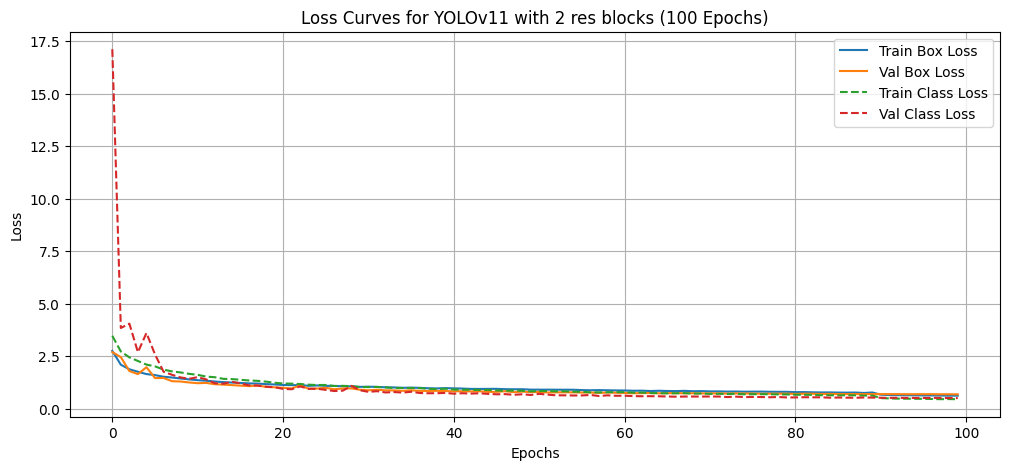

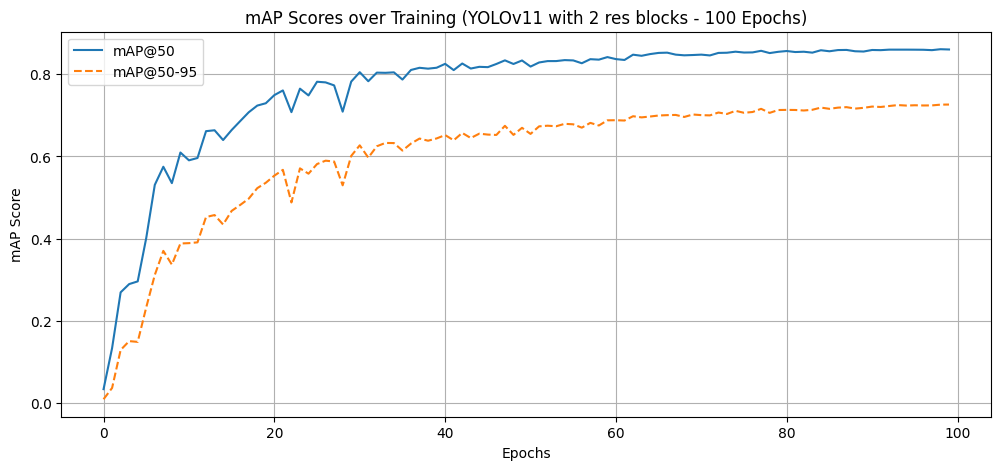

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
# Path to YOLOv11 training logs (results.csv file)
yolov11_results_csv = "/kaggle/working/yolov9m_cbam_results/clcxray_cbam_results/results.csv"

# Load training log
df = pd.read_csv(yolov11_results_csv)

# Plot Loss Curves
plt.figure(figsize=(12, 5))
plt.plot(df["train/box_loss"], label="Train Box Loss")
plt.plot(df["val/box_loss"], label="Val Box Loss")
plt.plot(df["train/cls_loss"], label="Train Class Loss", linestyle="dashed")
plt.plot(df["val/cls_loss"], label="Val Class Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves for YOLOv11 with 2 res blocks (100 Epochs)")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy (mAP@50)
plt.figure(figsize=(12, 5))
plt.plot(df["metrics/mAP50(B)"], label="mAP@50")
plt.plot(df["metrics/mAP50-95(B)"], label="mAP@50-95", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("mAP Score")
plt.title("mAP Scores over Training (YOLOv11 with 2 res blocks - 100 Epochs)")
plt.legend()
plt.grid()
plt.show()

In [29]:
# Extract IoU values from training logs
iou_values = df["metrics/mAP50-95(B)"]

# Print Final IoU Score
final_iou = iou_values.iloc[-1]  # Last epoch IoU
print(f"\n🔹 **Final IoU (Intersection over Union): {final_iou:.4f}**")


🔹 **Final IoU (Intersection over Union): 0.7263**


In [30]:
from ultralytics import YOLO

# Load the trained model
model = YOLO("/kaggle/working/yolov9m_cbam_results/clcxray_cbam_results/weights/best.pt")

# Run prediction on test images
model.predict(
    source="/kaggle/input/clc-xrayy/test/images",  # ✅ path to test images
    save=True,
    save_txt=True,
    project="/kaggle/working/yolov9cbam_predictions",
    name="test_preds",
    imgsz=640,
    conf=0.25
)


image 1/956 /kaggle/input/clc-xrayy/test/images/05_20_27_625_png.rf.1b267931baa1f6e5d48667f95695d374.jpg: 640x608 1 VacuumCup, 66.3ms
image 2/956 /kaggle/input/clc-xrayy/test/images/05_24_05_796_png.rf.6194ae409d5a6b35cae0cea21bab968e.jpg: 640x480 2 PlasticBottles, 59.3ms
image 3/956 /kaggle/input/clc-xrayy/test/images/05_24_40_875_png.rf.9df32b927a67834ac6efc6631c0798d2.jpg: 640x640 1 PlasticBottle, 1 Tin, 37.6ms
image 4/956 /kaggle/input/clc-xrayy/test/images/05_25_25_703_png.rf.b3ffc7590a2072577e2c6a62a66c73dd.jpg: 640x640 1 PlasticBottle, 2 VacuumCups, 30.6ms
image 5/956 /kaggle/input/clc-xrayy/test/images/05_27_15_406_png.rf.af1ec5b23304c5086affa15bbacd953a.jpg: 640x640 1 VacuumCup, 30.7ms
image 6/956 /kaggle/input/clc-xrayy/test/images/05_29_34_453_png.rf.b4ab31f1dd47ba90e59109ed8fbb45b0.jpg: 352x640 1 PlasticBottle, 1 VacuumCup, 62.6ms
image 7/956 /kaggle/input/clc-xrayy/test/images/05_34_07_015_png.rf.a3df24d6667e9dd0e02ffbf7bcdea42a.jpg: 416x640 5 PlasticBottles, 1 Tin, 60.1m

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'gun-knife-wrench-pilers-scissors', 1: 'Cans', 2: 'CartonDrinks', 3: 'GlassBottle', 4: 'PlasticBottle', 5: 'SprayCans', 6: 'SwissArmyKnife', 7: 'Tin', 8: 'VacuumCup', 9: 'blade', 10: 'dagger', 11: 'knife', 12: 'scissors'}
 obb: None
 orig_img: array([[[244, 236, 169],
         [244, 236, 169],
         [244, 236, 169],
         ...,
         [243, 237, 164],
         [245, 239, 166],
         [245, 239, 166]],
 
        [[244, 236, 169],
         [244, 236, 169],
         [244, 236, 169],
         ...,
         [243, 237, 164],
         [245, 239, 166],
         [245, 239, 166]],
 
        [[244, 236, 169],
         [244, 236, 169],
         [244, 236, 169],
         ...,
         [244, 238, 167],
         [245, 239, 168],
         [245, 239, 168]],
 
        ...,
 
        [[242, 236, 165],
         [242, 236, 165],
         [241, 234,

Total prediction images found: 956


/tmp/ipykernel_35/1692378009.py:29: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


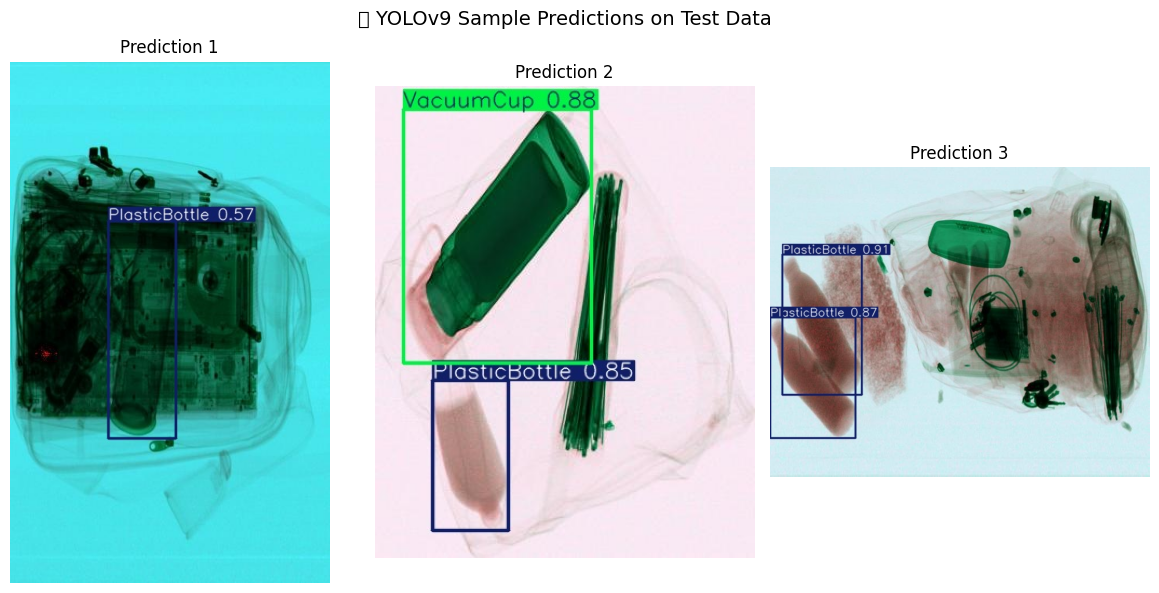

In [34]:
import cv2
import random
import os
import matplotlib.pyplot as plt

# Path where predictions are saved
pred_path = "/kaggle/working/yolov9cbam_predictions/test_preds"


# Get prediction images
image_files = [f for f in os.listdir(pred_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
print(f"Total prediction images found: {len(image_files)}")

# Safely sample up to 3 images
sample_size = min(3, len(image_files))
sample_files = random.sample(image_files, sample_size)

# Plot them
plt.figure(figsize=(12, 6))
for i, file in enumerate(sample_files):
    img = cv2.imread(os.path.join(pred_path, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(f"Prediction {i+1}")
    plt.axis("off")

plt.suptitle("🔹 YOLOv9 Sample Predictions on Test Data", fontsize=14)
plt.tight_layout()
plt.show()
